# Recommendation system for games in Steam
Given *Steam games' description*, we try to predict similar games to each other. 

We will use a TensorFlow dense layers with dropouts in between to make our predictions.

The dataset: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset?select=games.json.

# Imports

In [172]:
%reset -f

import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.models import Model

from tensorflow.python.ops import math_ops

# Prepare dataset

In [173]:
games_metadata = {}
with open('dataset/games_metadata.json') as f:
    games_metadata = json.load(f)

len(games_metadata)

85103

Clear games with almost no reviews.

In [174]:
rem = [appid for appid, gm in games_metadata.items() if gm['positive'] + gm['negative'] <= 20]

for key in rem:
    del games_metadata[key]

len(games_metadata)

32932

Load the json metadata into a pandas dataframe.

In [175]:
appids = []
prices = []
positive = []
negative = []
positive_percs = []
average_playtimes = []
descriptions = []

def convert_json_to_pandas():
    for i, (appid, gm) in enumerate(games_metadata.items()):
        appids.append(int(appid))
        prices.append(gm['price'])
        positive.append(gm['positive'])
        negative.append(gm['negative'])
        positive_percs.append((1 + gm['positive']) / (1 + gm['positive'] + gm['negative']))
        average_playtimes.append(gm['average_playtime_forever'])
        
        atg = gm['about_the_game']
        dd = gm['detailed_description']
        if len(atg) > len(dd):
            descriptions.append(atg)
        else:
            descriptions.append(dd)        

    return pd.DataFrame({
        'appid': appids,
        'price': prices,
        'positive_perc': positive_percs,
        'average_plt': average_playtimes,
    })

In [176]:
games = convert_json_to_pandas()
games

,appid,price,positive_perc,average_plt
0,655370,0.99,0.915254,0
1,1139950,0.00,0.864407,0
2,1469160,0.00,0.642336,0
3,1659180,10.99,0.758621,0
4,1178150,14.99,0.927711,0
...,...,...,...,...
32927,2160220,7.99,0.960000,0
32928,2487350,17.76,0.949126,0
32929,2642700,7.64,0.623188,0
32930,2674190,2.54,0.909091,0


Attach descriptions in vectorized format into the dataframe.

In [177]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions).toarray()

tfidf_df = pd.DataFrame(tfidf_matrix, index=appids)
tfidf_df.columns = [f'tfidf_{i}' for i in range(tfidf_df.shape[1])]

tfidf_df

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
655370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.182488,0.000000,0.000000,0.000000,0.000000,0.243500,0.000000,0.000000,0.271614,0.293291
1139950,0.207205,0.142348,0.000000,0.090211,0.000000,0.166137,0.054517,0.000000,0.079458,0.000000,...,0.000000,0.000000,0.000000,0.127388,0.247487,0.084773,0.125806,0.000000,0.063041,0.136144
1469160,0.000000,0.000000,0.000000,0.046001,0.000000,0.000000,0.417002,0.088347,0.040518,0.054282,...,0.000000,0.000000,0.000000,0.000000,0.063101,0.086457,0.128305,0.201286,0.289319,0.069424
1659180,0.091695,0.000000,0.000000,0.000000,0.000000,0.147042,0.048251,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.111449,0.112746,0.000000,0.150060,0.111346,0.174681,0.278977,0.180745
1178150,0.000000,0.000000,0.109616,0.000000,0.000000,0.065291,0.428504,0.000000,0.062454,0.000000,...,0.000000,0.000000,0.000000,0.100126,0.097262,0.000000,0.000000,0.077564,0.247749,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160220,0.000000,0.000000,0.048968,0.000000,0.046765,0.116669,0.287134,0.060833,0.167397,0.112131,...,0.133846,0.000000,0.044214,0.044729,0.000000,0.059532,0.066260,0.069299,0.000000,0.047803
2487350,0.000000,0.098376,0.096381,0.062344,0.000000,0.000000,0.452118,0.059867,0.109825,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.085518,0.000000,0.000000,0.204596,0.043567,0.047044
2642700,0.000000,0.000000,0.000000,0.000000,0.063206,0.039422,0.258724,0.041111,0.037709,0.101037,...,0.000000,0.129854,0.119518,0.060455,0.000000,0.040231,0.059704,0.000000,0.000000,0.000000
2674190,0.133215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136876,...,0.000000,0.175916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162119,0.000000


In [178]:
games = games.set_index('appid').join(tfidf_df)
games

,price,positive_perc,average_plt,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
appid,,,,,,,,,,,,,,,,,,,,,
655370,0.99,0.915254,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.182488,0.000000,0.000000,0.000000,0.000000,0.243500,0.000000,0.000000,0.271614,0.293291
1139950,0.00,0.864407,0,0.207205,0.142348,0.000000,0.090211,0.000000,0.166137,0.054517,...,0.000000,0.000000,0.000000,0.127388,0.247487,0.084773,0.125806,0.000000,0.063041,0.136144
1469160,0.00,0.642336,0,0.000000,0.000000,0.000000,0.046001,0.000000,0.000000,0.417002,...,0.000000,0.000000,0.000000,0.000000,0.063101,0.086457,0.128305,0.201286,0.289319,0.069424
1659180,10.99,0.758621,0,0.091695,0.000000,0.000000,0.000000,0.000000,0.147042,0.048251,...,0.000000,0.000000,0.111449,0.112746,0.000000,0.150060,0.111346,0.174681,0.278977,0.180745
1178150,14.99,0.927711,0,0.000000,0.000000,0.109616,0.000000,0.000000,0.065291,0.428504,...,0.000000,0.000000,0.000000,0.100126,0.097262,0.000000,0.000000,0.077564,0.247749,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160220,7.99,0.960000,0,0.000000,0.000000,0.048968,0.000000,0.046765,0.116669,0.287134,...,0.133846,0.000000,0.044214,0.044729,0.000000,0.059532,0.066260,0.069299,0.000000,0.047803
2487350,17.76,0.949126,0,0.000000,0.098376,0.096381,0.062344,0.000000,0.000000,0.452118,...,0.000000,0.000000,0.000000,0.000000,0.085518,0.000000,0.000000,0.204596,0.043567,0.047044
2642700,7.64,0.623188,0,0.000000,0.000000,0.000000,0.000000,0.063206,0.039422,0.258724,...,0.000000,0.129854,0.119518,0.060455,0.000000,0.040231,0.059704,0.000000,0.000000,0.000000


We would split the data into bins according to price and almost average play time. After testing I found these values to be working the best.

In [179]:
price_bins = [-float('inf'), 0.00, 10.00, 20.00, float('inf')]
games['price_bin'] = pd.cut(games['price'], bins=price_bins, labels=[f'price_{i}' for i in range(len(price_bins)-1)])

games.drop(columns=['price'], inplace=True)
games = pd.get_dummies(games, columns=['price_bin'])
games = games.astype('float')

games

,positive_perc,average_plt,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,...,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,price_bin_price_0,price_bin_price_1,price_bin_price_2,price_bin_price_3
appid,,,,,,,,,,,,,,,,,,,,,
655370,0.915254,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.243500,0.000000,0.000000,0.271614,0.293291,0.0,1.0,0.0,0.0
1139950,0.864407,0.0,0.207205,0.142348,0.000000,0.090211,0.000000,0.166137,0.054517,0.000000,...,0.247487,0.084773,0.125806,0.000000,0.063041,0.136144,1.0,0.0,0.0,0.0
1469160,0.642336,0.0,0.000000,0.000000,0.000000,0.046001,0.000000,0.000000,0.417002,0.088347,...,0.063101,0.086457,0.128305,0.201286,0.289319,0.069424,1.0,0.0,0.0,0.0
1659180,0.758621,0.0,0.091695,0.000000,0.000000,0.000000,0.000000,0.147042,0.048251,0.000000,...,0.000000,0.150060,0.111346,0.174681,0.278977,0.180745,0.0,0.0,1.0,0.0
1178150,0.927711,0.0,0.000000,0.000000,0.109616,0.000000,0.000000,0.065291,0.428504,0.000000,...,0.097262,0.000000,0.000000,0.077564,0.247749,0.000000,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160220,0.960000,0.0,0.000000,0.000000,0.048968,0.000000,0.046765,0.116669,0.287134,0.060833,...,0.000000,0.059532,0.066260,0.069299,0.000000,0.047803,0.0,1.0,0.0,0.0
2487350,0.949126,0.0,0.000000,0.098376,0.096381,0.062344,0.000000,0.000000,0.452118,0.059867,...,0.085518,0.000000,0.000000,0.204596,0.043567,0.047044,0.0,0.0,1.0,0.0
2642700,0.623188,0.0,0.000000,0.000000,0.000000,0.000000,0.063206,0.039422,0.258724,0.041111,...,0.000000,0.040231,0.059704,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0


In [180]:
average_plt_bins = [-float('inf'), 0, 10, 100, 1000, float('inf')] 
games['average_plt_bin'] = pd.cut(games['average_plt'], bins=average_plt_bins, labels=[f'average_plt_{i}' for i in range(len(average_plt_bins)-1)])

games.drop(columns=['average_plt'], inplace=True)
games = pd.get_dummies(games, columns=['average_plt_bin'])
games = games.astype('float')

games

,positive_perc,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,...,tfidf_99,price_bin_price_0,price_bin_price_1,price_bin_price_2,price_bin_price_3,average_plt_bin_average_plt_0,average_plt_bin_average_plt_1,average_plt_bin_average_plt_2,average_plt_bin_average_plt_3,average_plt_bin_average_plt_4
appid,,,,,,,,,,,,,,,,,,,,,
655370,0.915254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.293291,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1139950,0.864407,0.207205,0.142348,0.000000,0.090211,0.000000,0.166137,0.054517,0.000000,0.079458,...,0.136144,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1469160,0.642336,0.000000,0.000000,0.000000,0.046001,0.000000,0.000000,0.417002,0.088347,0.040518,...,0.069424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1659180,0.758621,0.091695,0.000000,0.000000,0.000000,0.000000,0.147042,0.048251,0.000000,0.000000,...,0.180745,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1178150,0.927711,0.000000,0.000000,0.109616,0.000000,0.000000,0.065291,0.428504,0.000000,0.062454,...,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160220,0.960000,0.000000,0.000000,0.048968,0.000000,0.046765,0.116669,0.287134,0.060833,0.167397,...,0.047803,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2487350,0.949126,0.000000,0.098376,0.096381,0.062344,0.000000,0.000000,0.452118,0.059867,0.109825,...,0.047044,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2642700,0.623188,0.000000,0.000000,0.000000,0.000000,0.063206,0.039422,0.258724,0.041111,0.037709,...,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Models

Chose autoencoder to compress the data into smaller domain.

The loss function I use is `cosine_similarity` because a lot of the data is provided by a vectorazation engine so this similarity made the most sense.

#### Define small model

In [201]:
class AutoencoderSmall(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoencoderSmall, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Input((input_dim,)),
            Dense(20, activation='relu'),
            Dropout(0.2),
            Dense(self.latent_dim, activation='tanh') 
        ])
        self.decoder = Sequential([
            Input((self.latent_dim,)),
            Dense(20, activation='relu'),
            Dropout(0.2),
            Dense(input_dim, activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [202]:
model = AutoencoderSmall(games.shape[1], 5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='cosine_similarity')

model.fit(games, games, epochs=50, batch_size=100, validation_split=0.2);

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: -0.4929 - val_loss: -0.7102
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: -0.7317 - val_loss: -0.8218
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: -0.8424 - val_loss: -0.8617
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: -0.8757 - val_loss: -0.8899
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: -0.8933 - val_loss: -0.8934
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: -0.8951 - val_loss: -0.8950
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: -0.8971 - val_loss: -0.8961
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: -0.8988 - val_loss: -0.8972
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: -0.8987 - val_loss: -0.8980
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: -0.9012 - val_loss: -0.8989
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: -0.9014 - val_loss: -0.8995
Epoch 12

#### Big Model

In [206]:
class AutoencoderBig(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoencoderBig, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Input((input_dim,)),
            Dense(200, activation='relu'),
            Dropout(0.2),
            Dense(50, activation='relu'),
            Dropout(0.2), 
            Dense(self.latent_dim, activation='tanh') 
        ])
        self.decoder = Sequential([
            Input((self.latent_dim,)),
            Dense(50, activation='relu'),
            Dropout(0.2), 
            Dense(200, activation='relu'),
            Dropout(0.2),
            Dense(input_dim, activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [209]:
model = AutoencoderBig(games.shape[1], 20)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='cosine_similarity')

model.fit(games, games, epochs=50, batch_size=100, validation_split=0.2);

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: -0.5906 - val_loss: -0.8946
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: -0.9130 - val_loss: -0.9335
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: -0.9307 - val_loss: -0.9390
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: -0.9360 - val_loss: -0.9434
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: -0.9406 - val_loss: -0.9460
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.9429 - val_loss: -0.9478
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: -0.9446 - val_loss: -0.9494
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: -0.9459 - val_loss: -0.9503
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.9472 - val_loss: -0.9514
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.9480 - val_loss: -0.9520
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: -0.9490 - val_loss: -0.9530
Epoch 12/50
264/

The big model is performing a lot better, we can deduce that from the losses.

# Example usage

Vizualization of the latent space.

In [210]:
games_encoded = model.encoder(games)
games_encoded

<tf.Tensor: shape=(32932, 20), dtype=float32, numpy=
array([[ 0.3127237 ,  0.6789592 , -0.28662506, ...,  0.23003466,
         0.1830747 , -0.19975041],
       [-0.4499881 ,  0.4377392 , -0.07725588, ...,  0.06863587,
         0.4785255 ,  0.98746234],
       [-0.2485139 ,  0.33295336, -0.29236677, ...,  0.04487947,
         0.00204555,  0.9840972 ],
       ...,
       [-0.20538595,  0.37448955, -0.3027705 , ..., -0.01007957,
         0.08411063, -0.37908822],
       [ 0.27662233,  0.18637007,  0.2618587 , ...,  0.1222547 ,
         0.7919146 , -0.4578663 ],
       [ 0.181703  ,  0.37450734, -0.11407047, ...,  0.46251145,
         0.36050004, -0.4369833 ]], dtype=float32)>

In [214]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def find_closest(appid, count=5):
    ind = games.index.get_loc(appid)
    enc = games_encoded[ind]
    
    srt = sorted(range(games.shape[0]), key=lambda x: cosine_similarity(enc, games_encoded[x]))
    srt = reversed(srt)
    srt = filter(lambda x: x != ind, srt)
    srt = list(map(lambda x: games.index[x], srt))
    
    return srt[0:count]

def full_recc(appid):
    recc = find_closest(appid)
    print(f"For {games_metadata[str(appid)]['name']} -> {[games_metadata[str(x)]['name'] for x in recc]}")

In [213]:
# Stardew valley
full_recc(413150)

For Stardew Valley -> ['Starbound', 'Griftlands', 'theHunter: Call of the Wild™', 'Atomicrops', 'Littlewood']


In [215]:
# Starbound
full_recc(211820)

For Starbound -> ['Stardew Valley', 'Curious Expedition 2', 'Galactic Mining Corp', 'Spelunky 2', 'Franchise Hockey Manager 6']


Stardew valley:

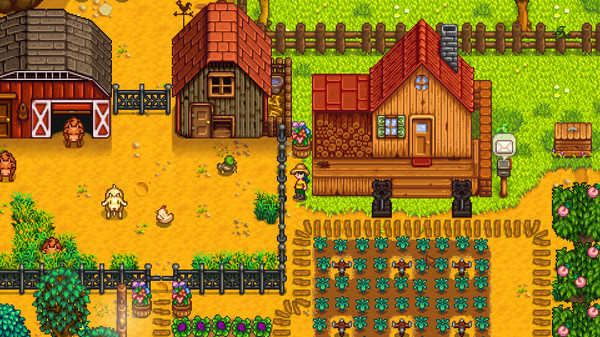



Starbound:

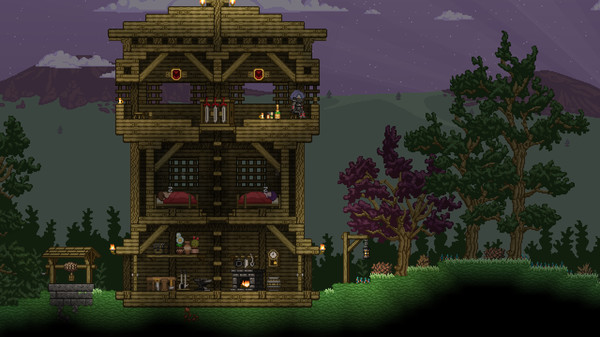